In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [2]:
import matplotlib.pyplot as plt
#import matplotlib.ticker as mticker
import folium
from folium import Choropleth, Circle, Marker
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
%matplotlib inline
import makeplot as mk

The dataset is from the Council Grove gas reservoir in Southwest Kansas. The log data is from 9 wells that have been labeled with a 9 different facies type based on oberservation of core:

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8


The data has 7 features:
* Five wire line log curves include gamma ray (GR), resistivity logging (ILD_log10),
photoelectric effect (PE), neutron-density porosity difference and average neutron-density porosity(DeltaPHI and PHIND). 
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

In [3]:
df =  pd.read_csv('data/training_data.csv')
df

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [4]:
blind = df[df['Well Name'] == 'SHANKLE']
training_data = df[df['Well Name'] != 'SHANKLE']


In [5]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']


facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]



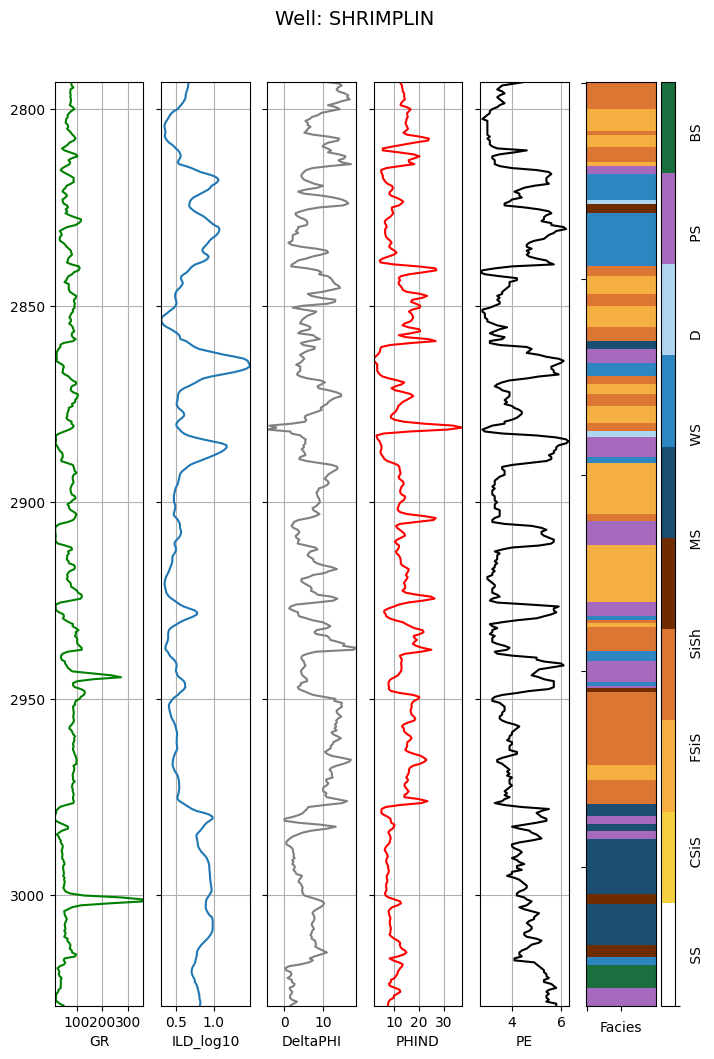

In [6]:
mk.facies_plot2(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

## missing/duplication

In [7]:
df.replace(-999.25, np.nan, inplace=True)

In [8]:
df.isna().sum()

Facies       0
Formation    0
Well Name    0
Depth        0
GR           0
ILD_log10    0
DeltaPHI     0
PHIND        0
PE           0
NM_M         0
RELPOS       0
dtype: int64

In [9]:
df.duplicated().sum()

1

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [12]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000
mean,66.249445,0.644637,3.754963,13.118929,3.805693,1.523895,0.523057
std,31.610849,0.241922,5.045916,7.389665,0.894118,0.499518,0.287499
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.081500,0.497000,1.300000,8.165000,3.200000,1.000000,0.276500
50%,65.541000,0.627000,3.581000,11.900000,3.600000,2.000000,0.529000
75%,80.714000,0.812323,6.500000,16.144000,4.400000,2.000000,0.771500
max,361.150000,1.480000,18.500000,84.400000,8.094000,2.000000,1.000000


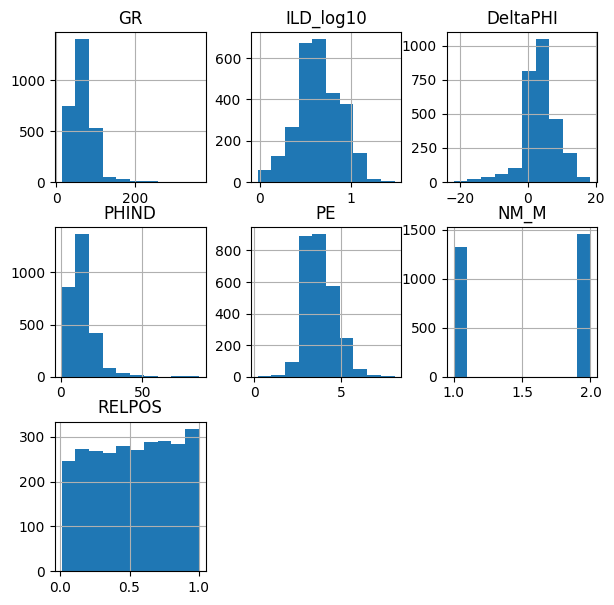

In [13]:
num_data = feature_vectors.select_dtypes(include = np.number)
num_data.hist(figsize=(7,7));

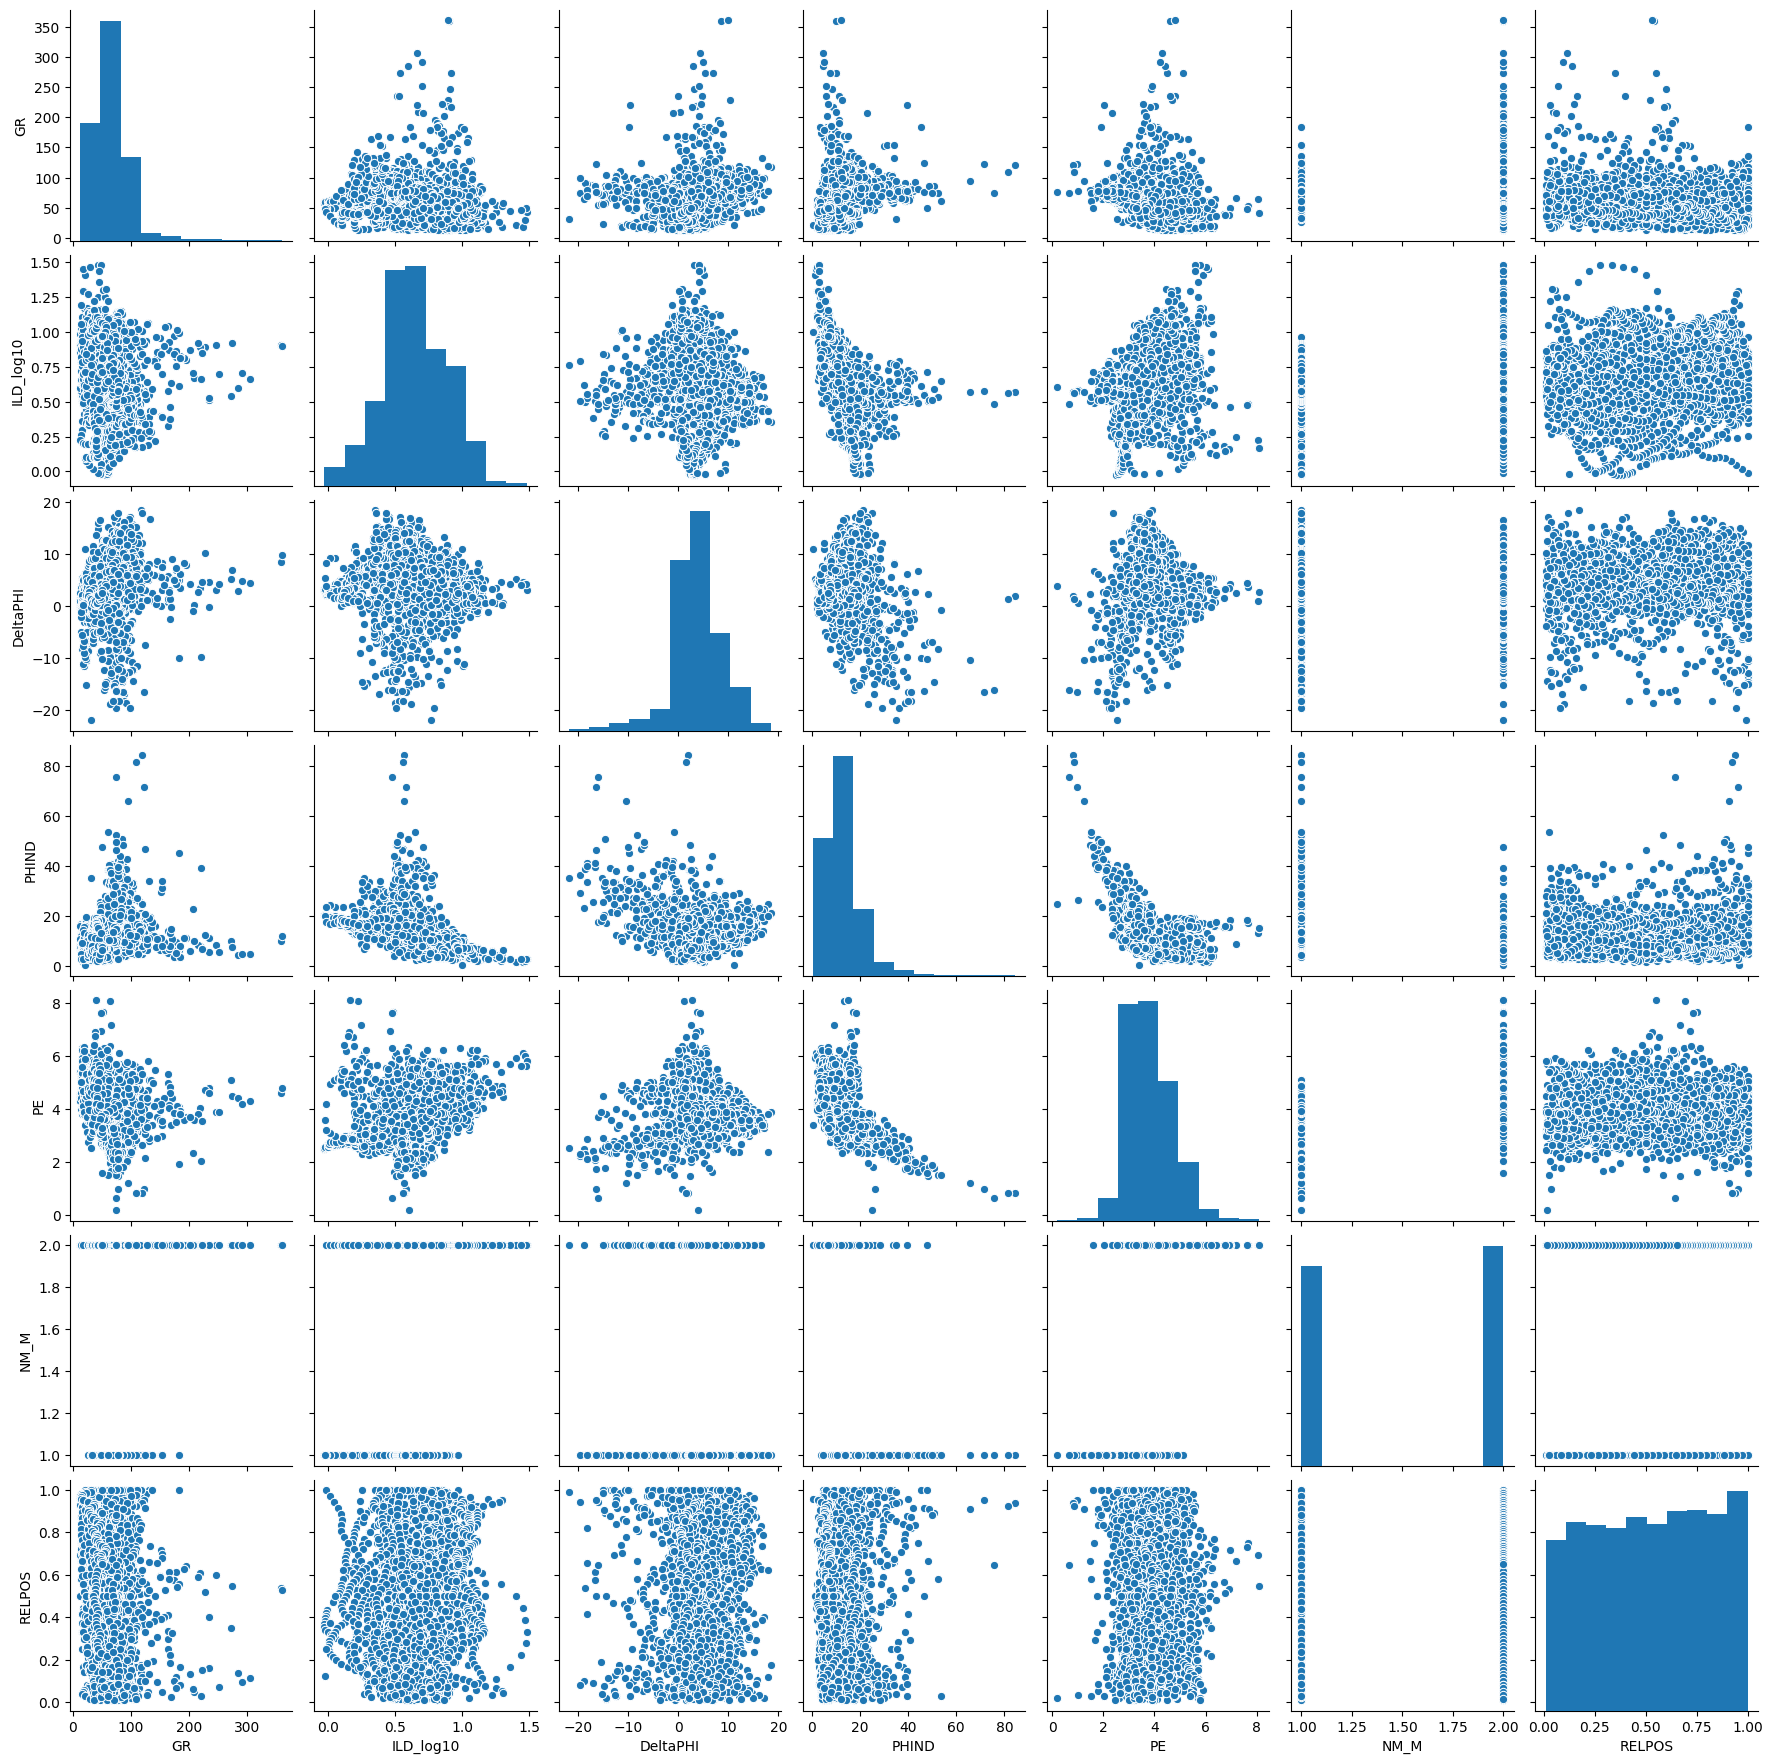

In [14]:
sns.pairplot(feature_vectors)


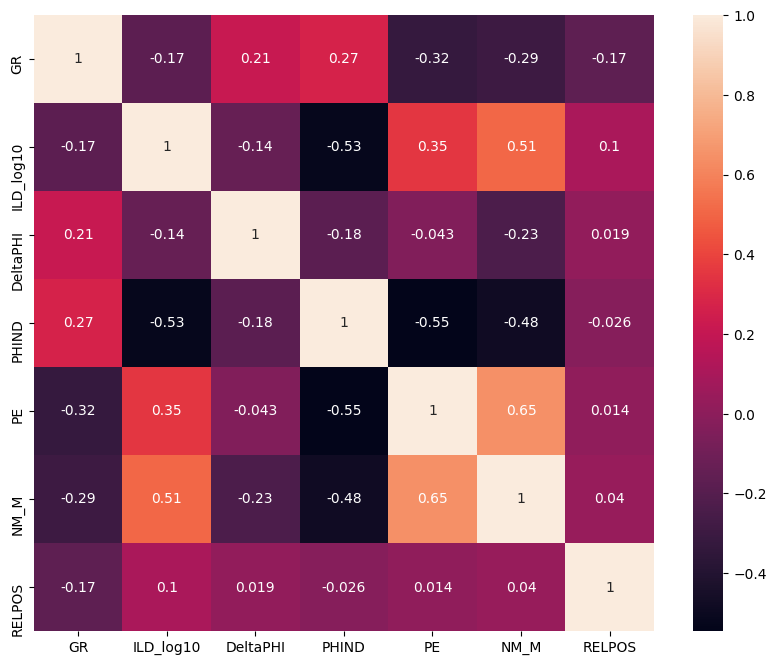

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.heatmap(feature_vectors.corr(), annot=feature_vectors.corr(), ax=ax);


SS      259
CSiS    738
FSiS    615
SiSh    184
MS      217
WS      462
D        98
PS      497
BS      161
Name: Facies, dtype: int64

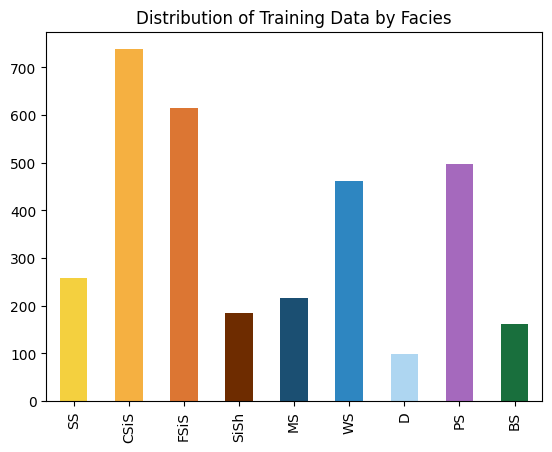

In [16]:
number_facies = df['Facies'].value_counts().sort_index()
number_facies.index = facies_labels

number_facies.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
number_facies

In [17]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.1, random_state=42)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression(max_iter=3000).fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

linear_score = accuracy_score(y_test, y_pred)

linear_score

0.5627240143369175

In [20]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train,y_train)
predicted_labels = clf.predict(X_test)

In [21]:
clf = svm.SVC(C=10, gamma=1)        
clf.fit(X_train, y_train)

accuracy_score(y_test, clf.predict(X_test))

0.7132616487455197

In [22]:
y_blind = blind['Facies'].values
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)

In [23]:
X_blind = scaler.transform(well_features)

In [24]:
y_pred = clf.predict(X_blind)
blind['Prediction'] = y_pred

/tmp/ipykernel_5634/3557188222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blind['Prediction'] = y_pred


In [25]:
accuracy_score(y_blind, y_pred)

0.44543429844098

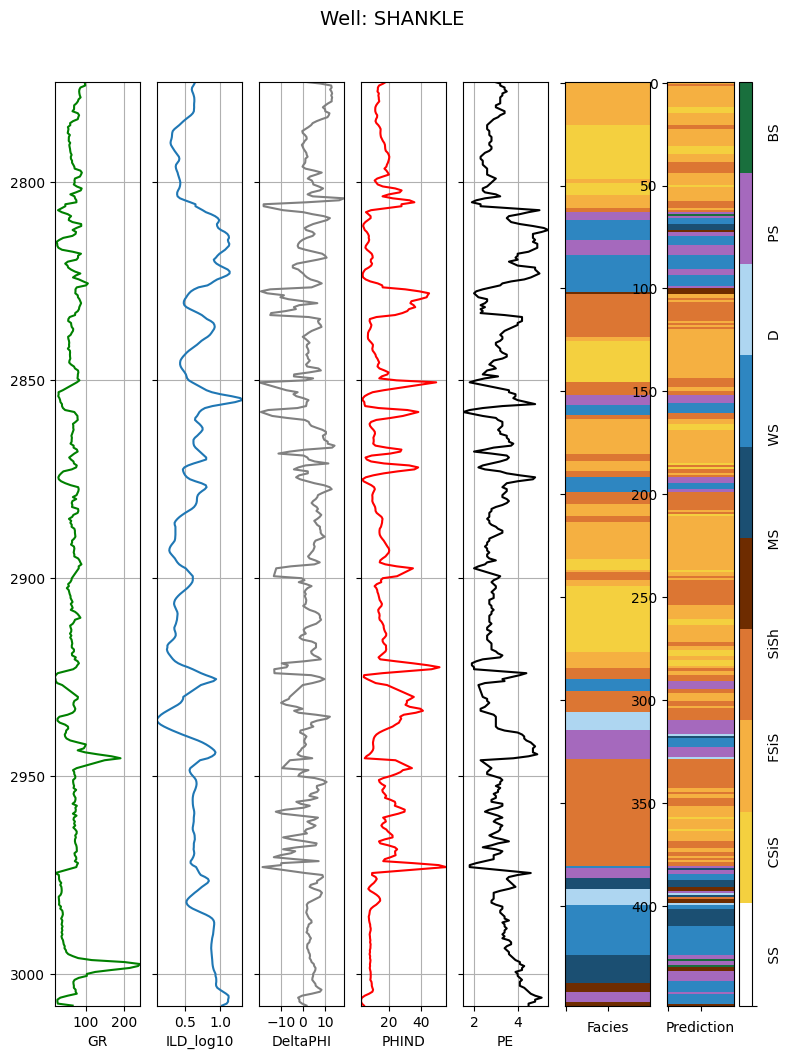

In [26]:
mk.compare_facies_plot(blind, 'Prediction', facies_colors)

## Any idea how we can make it better?